# Bayesian Optimization (2)

I ran RayStation on the same fine grid as before, but this time I also saved the PTV maximum dose values and the dose-volume histograms. Here I use Bayesian optimization to try to minimize the OAR dose so that the PTV maximum is within 2% of the approved plan.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from skopt import gp_minimize

In [2]:
def plot_grid(results, label, point=None):
    plt.figure()
    plt.imshow(results[:, :], origin='lower')
    plt.xlabel('OAR Volume Parameter')
    plt.ylabel('OAR Dose Parameter')
    plt.yticks(np.arange(1, 21, 2), labels=np.arange(200, 2001, 200))
    plt.axis('auto')
    plt.colorbar(label=label)
    if point:
        plt.plot(point[0], point[1], 'ro')

## Load grid search results

In [3]:
# Load approved plan results
dvh_doses_approved = np.load('approved/dvh_doses_approved.npy')
dvh_oar_approved = np.load('approved/dvh_oar_approved.npy')
dvh_ptv_approved = np.load('approved/dvh_ptv_approved.npy')
oar_avg_approved = 318.4594544159879
ptv_d95_approved = 4800.13222492 
ptv_max_approved = dvh_doses_approved[-1]

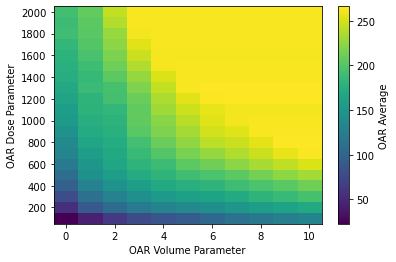

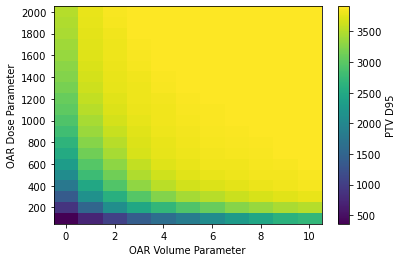

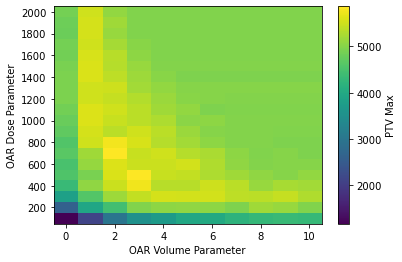

In [4]:
# Load results
oar_avg = np.load('5_28/oar_avg.npy')
ptv_d95 = np.load('5_28/ptv_d95.npy')
ptv_max = np.load('5_28/ptv_max.npy')
dvh_doses = np.load('5_28/dvh_doses.npy')
dvh_oar = np.load('5_28/dvh_oar.npy')
dvh_ptv = np.load('5_28/dvh_ptv.npy')

# Plot results
plot_grid(oar_avg[1:, :], 'OAR Average')
plot_grid(ptv_d95[1:, :], 'PTV D95')
plot_grid(ptv_max[1:, :], 'PTV Max')

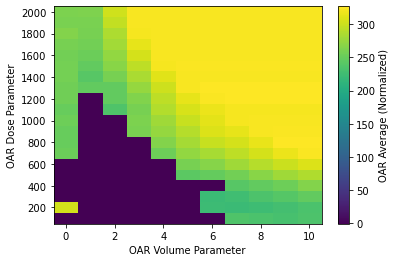

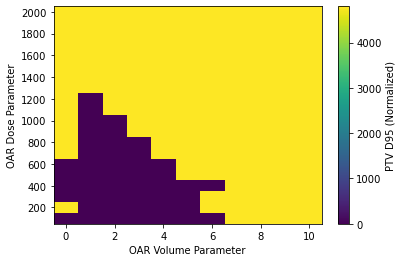

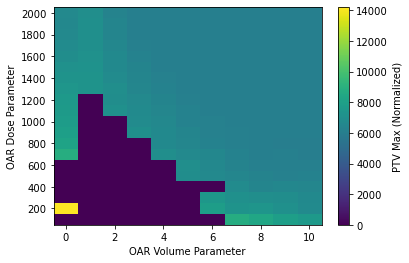

In [5]:
# Load normalized results
oar_avg_norm = np.load('5_28/oar_avg_norm.npy')
ptv_d95_norm = np.load('5_28/ptv_d95_norm.npy')
ptv_max_norm = np.load('5_28/ptv_max_norm.npy')
dvh_doses_norm = np.load('5_28/dvh_doses_norm.npy')
dvh_oar_norm = np.load('5_28/dvh_oar_norm.npy')
dvh_ptv_norm = np.load('5_28/dvh_ptv_norm.npy')

# Plot normalized results
plot_grid(oar_avg_norm[1:, :], 'OAR Average (Normalized)')
plot_grid(ptv_d95_norm[1:, :], 'PTV D95 (Normalized)')
plot_grid(ptv_max_norm[1:, :], 'PTV Max (Normalized)')

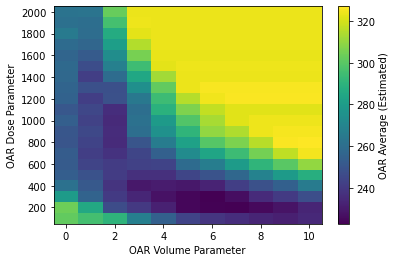

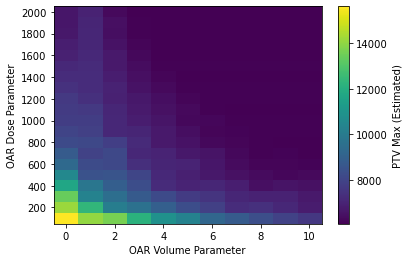

In [6]:
# Estimate missing data
idx = oar_avg_norm == -1
oar_avg_est = oar_avg_norm.copy()
oar_avg_est[idx] = 4800*oar_avg[idx]/ptv_d95[idx]
ptv_max_est = ptv_max_norm.copy()
ptv_max_est[idx] = 4800*ptv_max[idx]/ptv_d95[idx]

# Plot estimated data
plot_grid(oar_avg_est[1:, :], 'OAR Average (Estimated)')
plot_grid(ptv_max_est[1:, :], 'PTV Max (Estimated)') 

Find lowest OAR average dose where PTV max is within 2% of the approved plan.

Dose: 700, Volume: 8, OAR dose: 305.3155093804993, PTV Max: 6151.126953125
OAR % Decrease: 4.127352745608658
PTV % Increase: 1.2343714641321566


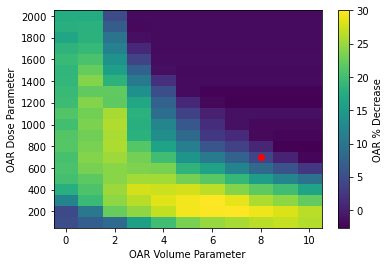

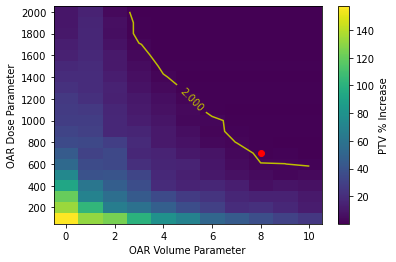

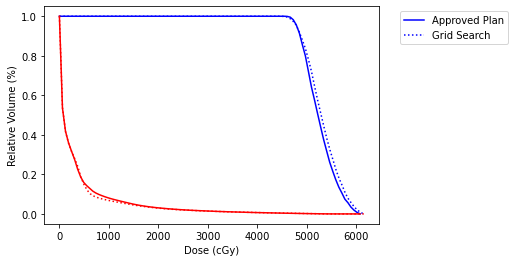

In [7]:
# Find optimal point with constraint
min_dose = 1e6

opt_dose = -1
opt_volume = -1
for ii in range(21):
    for jj in range(11):
        if oar_avg_est[ii, jj] < min_dose and (ptv_max_est[ii, jj] - ptv_max_approved)/ptv_max_approved <= 0.02:
            min_dose = oar_avg_est[ii, jj]
            opt_dose =  ii
            opt_volume = jj
print(f'Dose: {100*opt_dose}, Volume: {opt_volume}, OAR dose: {min_dose}, PTV Max: {ptv_max_est[opt_dose, opt_volume]}')

# Relative decrease/increase
oar_dec = 100*(oar_avg_approved - oar_avg_est)/oar_avg_approved
ptv_inc = 100*(ptv_max_est - ptv_max_approved)/ptv_max_approved
plot_grid(oar_dec[1:, :], 'OAR % Decrease', point=[opt_volume, opt_dose - 1])
plot_grid(ptv_inc[1:, :], 'PTV % Increase', point=[opt_volume, opt_dose - 1])
cs = plt.contour(ptv_inc[1:, :], [2], colors=['y'])
plt.clabel(cs)
print(f'OAR % Decrease: {oar_dec[opt_dose, opt_volume]}')
print(f'PTV % Increase: {ptv_inc[opt_dose, opt_volume]}')

# Plot DVH
plt.figure()
plt.plot(dvh_doses_approved, dvh_ptv_approved, 'b')
plt.plot(dvh_doses_norm[opt_dose, opt_volume], dvh_ptv_norm[opt_dose, opt_volume], 'b:')
plt.plot(dvh_doses_approved, dvh_oar_approved, 'r')
plt.plot(dvh_doses_norm[opt_dose, opt_volume], dvh_oar_norm[opt_dose, opt_volume], 'r:')
plt.xlabel('Dose (cGy)')
plt.ylabel('Relative Volume (%)')
plt.legend(bbox_to_anchor=[1.4, 1], labels=['Approved Plan', 'Grid Search']);

## Bayesian optimization

In [8]:
# Interpolate OAR average
volumes = np.arange(0, 11)
doses = np.arange(100, 2001, 100)
oar_avg_func = interpolate.interp2d(volumes, doses, oar_avg_est[1:, :])

# For gp_minimize, input needs to be a single vector, output needs to be scalar
def oar_avg_func2(pars):
    return oar_avg_func(pars[0], pars[1])[0]

# Interpolate PTV max
volumes = np.arange(0, 11)
doses = np.arange(100, 2001, 100)
ptv_max_func = interpolate.interp2d(volumes, doses, ptv_max_est[1:, :])

# For gp_minimize, input needs to be a single vector, output needs to be scalar
def ptv_max_func2(pars):
    return ptv_max_func(pars[0], pars[1])[0]

I don't know how to incorporate hard constraints into the function `gp_minimize`, so instead I minimize a convex combination of the OAR % decrease and the PTV % increase.

In [9]:
# Objective functions

weight = 0.75

def my_func(volumes, doses):
    oar = oar_avg_func(volumes, doses)
    ptv = ptv_max_func(volumes, doses)
    return (1 - weight)*(oar - oar_avg_approved)/oar_avg_approved + weight*(ptv - ptv_max_approved)/ptv_max_approved

def my_func2(pars):
    return my_func(pars[0], pars[1])[0]

In [10]:
# Optimize
r = gp_minimize(my_func2, dimensions=[(0, 10), (100, 2000)],
                x0=[7.5, 1500], y0=oar_avg_func2([7.5, 1500]),
                random_state=0, n_calls=25)
v_vals = [r.x_iters[ii][0] for ii in range(len(r.x_iters))]
d_vals = [r.x_iters[ii][1]/100-1 for ii in range(len(r.x_iters))]

# Print results
opt_volume2 = r.x[0]
opt_dose2 = r.x[1]
print(f'Dose: {opt_dose2}, Volume: {opt_volume2}, OAR dose: {oar_avg_func2(r.x)}, PTV Max: {ptv_max_func2(r.x)}')

# Relative decrease/increase
oar_dec2 = 100*(oar_avg_approved - oar_avg_func2(r.x))/oar_avg_approved
ptv_inc2 = 100*(ptv_max_func2(r.x) - ptv_max_approved)/ptv_max_approved
print(f'OAR % Decrease: {oar_dec2}')
print(f'PTV % Increase: {ptv_inc2}')

Dose: 548, Volume: 9, OAR dose: 289.6000416906954, PTV Max: 6219.94220703125
OAR % Decrease: 9.06219373458918
PTV % Increase: 2.3669231135180775


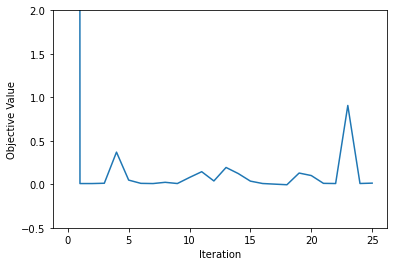

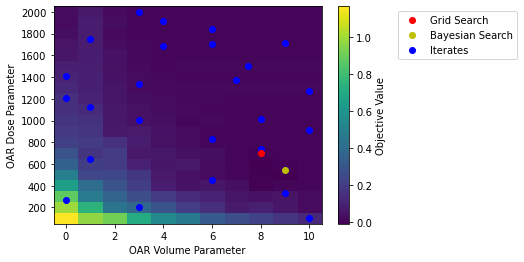

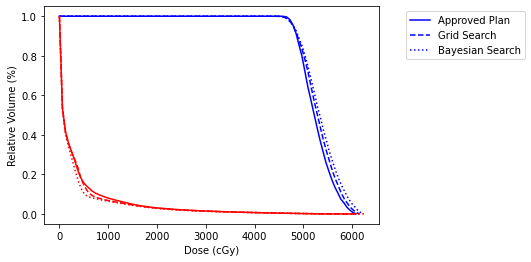

In [11]:
# Plot convergence
plt.plot(r.func_vals)
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.ylim([-0.5, 2])

# Plot iterates for objective function
plot_grid(my_func(np.arange(0, 11), np.arange(100, 2001, 100)), 'Objective Value')
plt.plot(opt_volume, opt_dose - 1, 'ro', zorder=3)
plt.plot(opt_volume2, opt_dose2/100 - 1, 'yo', zorder=3)
plt.plot(v_vals, d_vals, 'bo')
plt.legend(bbox_to_anchor=[1.75, 1], labels=['Grid Search', 'Bayesian Search', 'Iterates'])

# Plot DVH
plt.figure()
plt.plot(dvh_doses_approved, dvh_ptv_approved, 'b')
plt.plot(dvh_doses_norm[7, 8, :], dvh_ptv_norm[7, 8, :], 'b--')
plt.plot(dvh_doses_norm[5, 9, :], dvh_ptv_norm[5, 9, :], 'b:') # closest point

plt.plot(dvh_doses_approved, dvh_oar_approved, 'r')
plt.plot(dvh_doses_norm[7, 8, :], dvh_oar_norm[7, 8, :], 'r--')
plt.plot(dvh_doses_norm[5, 9, :], dvh_oar_norm[5, 9, :], 'r:')

plt.xlabel('Dose (cGy)')
plt.ylabel('Relative Volume (%)')
plt.legend(bbox_to_anchor=[1.45, 1], labels=['Approved Plan', 'Grid Search', 'Bayesian Search'])

## Relationships

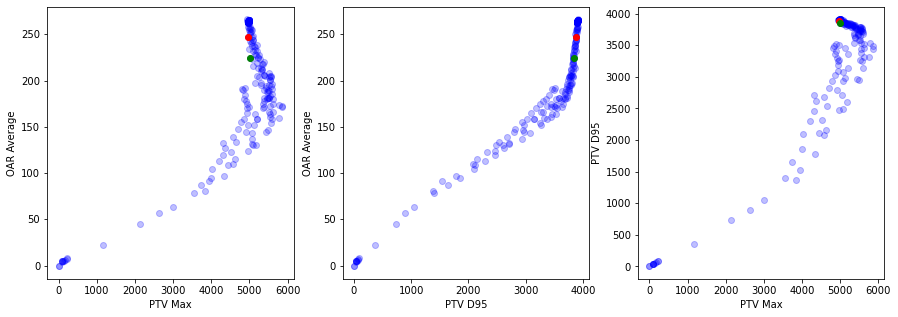

In [12]:
# Before normalization

oar_avg_grid = oar_avg[7, 8]
ptv_max_grid = ptv_max[7, 8]
ptv_d95_grid = ptv_d95[7, 8]

oar_avg_bay = oar_avg[5, 9] # closest point
ptv_max_bay = ptv_max[5, 9]
ptv_d95_bay = ptv_d95[5, 9]

fix, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(ptv_max, oar_avg, 'bo', alpha=0.25)
ax[0].plot(ptv_max_grid, oar_avg_grid, 'ro')
ax[0].plot(ptv_max_bay, oar_avg_bay, 'go')
ax[0].set_xlabel('PTV Max')
ax[0].set_ylabel('OAR Average')


ax[1].plot(ptv_d95, oar_avg, 'bo', alpha=0.25)
ax[1].plot(ptv_d95_grid, oar_avg_grid, 'ro')
ax[1].plot(ptv_d95_bay, oar_avg_bay, 'go')
ax[1].set_xlabel('PTV D95')
ax[1].set_ylabel('OAR Average')


ax[2].plot(ptv_max, ptv_d95, 'bo', alpha=0.25)
ax[2].plot(ptv_max_grid, ptv_d95_grid, 'ro')
ax[2].plot(ptv_max_bay, ptv_d95_bay, 'go')
ax[2].set_xlabel('PTV Max')
ax[2].set_ylabel('PTV D95');

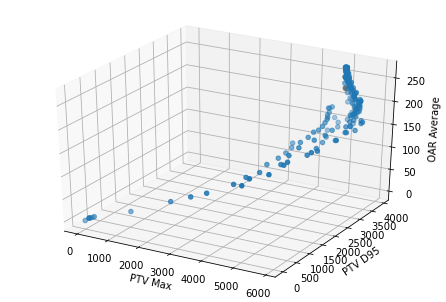

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(ptv_max, ptv_d95, oar_avg)
ax.scatter(ptv_max_bay, ptv_d95_bay, oar_avg_bay)
ax.scatter(ptv_max_grid, ptv_d95_grid, oar_avg_grid)
ax.set_xlabel('PTV Max')
ax.set_ylabel('PTV D95')
ax.set_zlabel('OAR Average');

# Can't really see them without rotation plot...

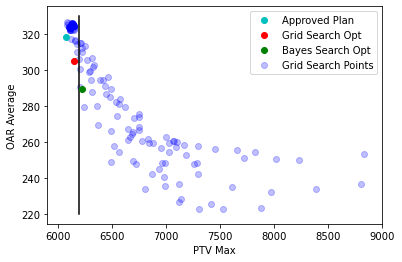

In [14]:
# After normalization

oar_avg_grid = 305.3155093804993
ptv_max_grid = 6151.126953125

oar_avg_bay = 289.6000416906954
ptv_max_bay = 6219.94220703125

idx = oar_avg_norm != -1
plt.plot(ptv_max_approved, oar_avg_approved, 'co', zorder=3)
plt.plot(ptv_max_grid, oar_avg_grid, 'ro', zorder=3)
plt.plot(ptv_max_bay, oar_avg_bay, 'go', zorder=3)
plt.plot(ptv_max_norm[idx], oar_avg_norm[idx], 'bo', alpha=0.25)
plt.plot([1.02*ptv_max_approved, 1.02*ptv_max_approved], [220, 330], 'k')
plt.xlim([5900, 9000])
plt.xlabel('PTV Max')
plt.ylabel('OAR Average')
plt.legend(['Approved Plan', 'Grid Search Opt', 'Bayes Search Opt', 'Grid Search Points'])

Text(0, 0.5, 'OAR Avg Norm')

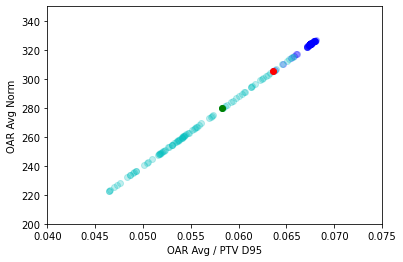

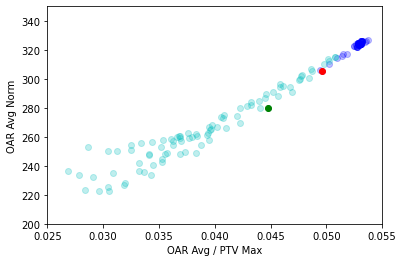

In [15]:
# After normalization

oar_avg_grid = oar_avg[7, 8]
ptv_max_grid = ptv_max[7, 8]
ptv_d95_grid = ptv_d95[7, 8]

oar_avg_bay = oar_avg[5, 9] # closest point
ptv_max_bay = ptv_max[5, 9]
ptv_d95_bay = ptv_d95[5, 9]

oar_avg_grid_norm = oar_avg_norm[7, 8]
oar_avg_bay_norm = oar_avg_norm[5, 9]

idx1 = (oar_avg != -1) * (ptv_max_norm <= 1.02*ptv_max_approved)
idx2 = (oar_avg != -1) * (ptv_max_norm > 1.02*ptv_max_approved)
plt.plot(oar_avg_grid/ptv_d95_grid, oar_avg_grid_norm, 'ro', zorder=3)
plt.plot(oar_avg_bay/ptv_d95_bay, oar_avg_bay_norm, 'go', zorder=3)
plt.plot(oar_avg[idx1]/ptv_d95[idx1], oar_avg_norm[idx1], 'bo', alpha=0.25)
plt.plot(oar_avg[idx2]/ptv_d95[idx2], oar_avg_norm[idx2], 'co', alpha=0.25)
plt.ylim([200, 350])
plt.xlim([0.04, 0.075])
plt.xlabel('OAR Avg / PTV D95')
plt.ylabel('OAR Avg Norm')

plt.figure()
plt.plot(oar_avg_grid/ptv_max_grid, oar_avg_grid_norm, 'ro', zorder=3)
plt.plot(oar_avg_bay/ptv_max_bay, oar_avg_bay_norm, 'go', zorder=3)
plt.plot(oar_avg[idx1]/ptv_max[idx1], oar_avg_norm[idx1], 'bo', alpha=0.25)
plt.plot(oar_avg[idx2]/ptv_max[idx2], oar_avg_norm[idx2], 'co', alpha=0.25)
plt.ylim([200, 350])
plt.xlim([0.025, 0.055])
plt.xlabel('OAR Avg / PTV Max')
plt.ylabel('OAR Avg Norm')